## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
ab = pd.read_csv('ab_data.csv')
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
ab.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
ab = ab.drop_duplicates()
ab.user_id.nunique()

290584

In [5]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.5+ MB


d. The proportion of users converted.

In [6]:
ab[ab.converted == 1].shape[0] / ab.shape[0]

0.11965919355605512

In [7]:
ab.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
len(ab[(ab.landing_page == "new_page") & (ab.group != "treatment")]) + len(ab[(ab.landing_page != "new_page") & (ab.group == "treatment")])

3893

f. Do any of the rows have missing values?

In [9]:
pd.isnull(ab).sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [10]:
pd.isna(ab).sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
control_df = ab[(ab.landing_page == "old_page") & (ab.group == "control")]
treat_df = ab[(ab.landing_page == "new_page") & (ab.group == "treatment")]
df2 = pd.concat([control_df, treat_df])
print(sum(df2.duplicated()))
df2.sort_values("timestamp", ascending = True, inplace=True)
df2.head()

0


,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
sum(df2.user_id.duplicated())

1

In [15]:
print (df2[df2.duplicated(subset=['user_id'],keep=False)]) 

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


c. What is the row information for the repeat **user_id**? 

In [16]:
 df2[df2.user_id == 773192 ]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2.drop_duplicates("user_id", inplace=True)

In [18]:
#remove the duplicated user_id in treatment Group
treat_df = df2[(df2.landing_page == "new_page")]
treat_df.shape

(145310, 5)

In [19]:
#counting the number of users in each group
print("Control group users=", df2.group[df2.group == "control"].count())
print("Treatment group users=",df2.group[df2.group == "treatment"].count())

Control group users= 145274
Treatment group users= 145310


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
control_df.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
treat_df.converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
df2[df2.landing_page == "new_page"]["user_id"].count() / df2["user_id"].count()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The new page didn't realy increase the number of converting:
The posterior probabilty of converting for Control group = 0.5032, while The posterior probabilty of converting for Treatment group = 0.4968**

This is a case of conditional probability: The prior probability of being on control page which in this case = 0.4999 by the conditional probabilty of being on the page and converiting which is = 0.1204 deviding by the normalizer which is all converts =0.4999. 0.1204/0.1196 = 0.5032

while The posterior probabilty of converting for Treatment group = prior probability of being on the treatment page which is 0.5001 multiplied by the conditional probabilty of being on page and converiting (0.1188) deviding by the normalizer and it is = 0.5001.0.1188/0.1196 = 0.4968, so the new page didn't realy increase the number of converting.

**As the data we have is for 3 weeks only, 2017-01-02 till 2017-01-24, we need more time to render a decision that neither page is better than another.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0:p_{new} cr - p_{old}cr = 0$$



$$H_1: p_{new}cr - p_{old}cr > 0$$


**p_{new}cr and p_{old}cr are the convert rate for the new page(treatment) and the old page(control), respectivley.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
#New page convert rate under the null hypothessis:
p_new = df2.user_id[df2.converted == 1].count() / df2["user_id"].count()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
#Old page convert rate under the null hypothessis:
p_old = df2.user_id[df2.converted == 1].count() / df2["user_id"].count()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [26]:
n_new = treat_df.shape[0]
n_new

145310

d. What is $n_{old}$?

In [27]:
n_old = control_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.binomial (n=1, p=p_new, size = n_new)
print (new_page_converted)

[0 0 0 ... 0 0 0]


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.binomial (n=1, p=p_old, size=n_old)
print (old_page_converted)

[0 0 1 ... 0 0 0]


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0015025933301557742

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [31]:
p_diffs = np.zeros([10000])
for i in range(10000):
    old_page_converted = np.random.binomial (n=1, p=p_old, size=n_old)
    new_page_converted = np.random.binomial (n=1, p=p_new, size =n_new)
    p_diffs[i] = new_page_converted.mean() - old_page_converted.mean()

(array([2.800e+01, 1.860e+02, 8.590e+02, 2.167e+03, 3.104e+03, 2.355e+03,
        1.001e+03, 2.620e+02, 3.500e+01, 3.000e+00]),
 array([-0.00430362, -0.00335933, -0.00241504, -0.00147075, -0.00052647,
         0.00041782,  0.00136211,  0.0023064 ,  0.00325069,  0.00419498,
         0.00513927]),
 <BarContainer object of 10 artists>)

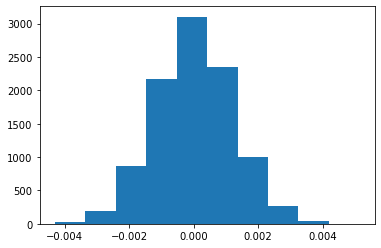

In [32]:
plt.hist(p_diffs)

In [33]:
diff_actual = treat_df.converted.mean() - control_df.converted.mean() 
diff_actual

-0.0015782389853555567

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
#Calculating the portion of p_diffs being larger than the actural difference between new and old pages.
(p_diffs > diff_actual).mean()

0.9056

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.stats.api as sms

convert_old = df2[df2.group == "control"]['converted']  
convert_new = df2[df2.group == "treatment"]['converted']
n_old = control_df.shape[0]
n_new = treat_df.shape[0]

con = sms.CompareMeans(sms.DescrStatsW(convert_old), sms.DescrStatsW(convert_new) )
print (con.tconfint_diff(usevar = "unequal"))

(-0.0007814002236428285, 0.0039378781943539415)


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([control_df[control_df.converted == 1].shape[0], treat_df[treat_df.converted == 1].shape[0]])
nobs = np.array([control_df.shape[0], treat_df.shape[0]])
stat, pval = proportions_ztest(count, nobs, alternative='smaller')
stat, pval

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

*the probability that the null hypothesis is the right hypothesis is 90%, and that the new page didn't increase the conversion rate,   
The z-score describes the standard deviations the value are away from the mean.*

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0


In [38]:
df3 = df2[['user_id', 'group','landing_page', 'converted']].copy()
df3.head()

,user_id,group,landing_page,converted
131228,922696,treatment,new_page,0
184884,781507,control,old_page,0
83878,737319,control,old_page,0
102717,818377,treatment,new_page,0
158789,725857,treatment,new_page,0


In [39]:
df3['ab_page'] = (df3['landing_page'] == 'new_page').astype(int)
df3['intercept'] = 1
df3.head()

,user_id,group,landing_page,converted,ab_page,intercept
131228,922696,treatment,new_page,0,1,1
184884,781507,control,old_page,0,0,1
83878,737319,control,old_page,0,0,1
102717,818377,treatment,new_page,0,1,1
158789,725857,treatment,new_page,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
logit_conv = sm.Logit(df3['converted'], df3[['intercept','ab_page']])
result = logit_conv.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:               8.077e-06
Time:                        19:42:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [42]:
np.exp(-0.0150)

0.9851119396030626

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

*The p-value associated with ab_page is the probablity of converting and being on treatment page, the value in part 2, describe the probablity of the hypothesis 0 being the right one.
in Part II we are doing a one-sided test*
In the regression model result the p-value tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis.* 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**As far as the test was for a short time then we might consider waiting for more time and consider the duration in our test, beside that we can take the age and job of those who convert and take it into our consideration while running the test.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [43]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [44]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [45]:
df_new.head()

,country,group,landing_page,converted,ab_page,intercept
user_id,,,,,,
834778,UK,control,old_page,0,0,1
928468,US,treatment,new_page,0,1,1
822059,UK,treatment,new_page,1,1,1
711597,UK,control,old_page,0,0,1
710616,UK,treatment,new_page,0,1,1


In [46]:
df_new[['UK', 'US', 'CA' ]] = pd.get_dummies(df_new['country'])
df_new = df_new.drop("country", axis =1)
df_new.head()

,group,landing_page,converted,ab_page,intercept,UK,US,CA
user_id,,,,,,,,
834778,control,old_page,0,0,1,0,1,0
928468,treatment,new_page,0,1,1,0,0,1
822059,treatment,new_page,1,1,1,0,1,0
711597,control,old_page,0,0,1,0,1,0
710616,treatment,new_page,0,1,1,0,1,0


In [47]:
logit_conv = sm.Logit(df_new['converted'], df_new[['intercept','US']])
result = logit_conv.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366120
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:               4.280e-06
Time:                        19:42:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3399
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9994      0.007   -302.640      0.000      -2.012      -1.986
US             0.0126      0.013      0.955      0.340      -0.013       0.038
==============================================================================
"""

In [48]:
logit_conv = sm.Logit(df_new['converted'], df_new[['intercept','UK']])
result = logit_conv.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:               1.259e-05
Time:                        19:42:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1016
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9941      0.006   -340.272      0.000      -2.006      -1.983
UK            -0.0434      0.027     -1.629      0.103      -0.096       0.009
==============================================================================
"""

In [49]:
logit_conv = sm.Logit(df_new['converted'], df_new[['intercept','CA']])
result = logit_conv.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366121
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:               7.678e-08
Time:                        19:42:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.8983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9951      0.010   -190.998      0.000      -2.016      -1.975
CA            -0.0016      0.012     -0.128      0.898      -0.026       0.023
==============================================================================
"""

**p_US = 0.340 , p_UK = 0.103 , p_CA = 0.898 , conversion rate in Canada is more than US and UK, then US come after Canada in the rate of converstion, so yes there is a difference in rate between these different coutnries.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [50]:
df_new['ab_page_US'] = df_new['ab_page'] * df_new['US']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']

final_model = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','UK','ab_page_US','ab_page_UK']])
final_model_result = final_model.fit()
final_model_result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:               3.482e-05
Time:                        19:42:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
ab_page_US     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page_UK    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

In [51]:
# for checking to be deleted if rehected
final_model_1 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK','CA','ab_page_UK','ab_page_CA']])
final_model_1_result = final_model_1.fit()
final_model_1_result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:               3.482e-05
Time:                        19:42:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
UK            -0.0118      0.040     -0.296      0.767      -0.090       0.066
CA             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_page_UK    -0.0783      0.057     -1.378      0.168      -0.190       0.033
ab_page_CA    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

In [52]:
# for checking to be deleted if rehected
final_model_2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','CA','ab_page_US','ab_page_CA']])
final_model_2_result = final_model_2.fit()
final_model_2_result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:               3.482e-05
Time:                        19:42:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0118      0.040      0.296      0.767      -0.066       0.090
CA             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page_US     0.0783      0.057      1.378      0.168      -0.033       0.190
ab_page_CA     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

final_model
ab_page	      0.132	
US		      0.760	
UK	          0.642	
ab_page_US	  0.238	
ab_page_UK	  0.383	


final_model_1
ab_page	      0.635	
UK		      0.767	
CA	          0.760	
ab_page_UK	  0.168	
ab_page_CA    0.238	


final_model_2
ab_page	      0.195
US		      0.767	
CA		      0.642	
ab_page_US	  0.168	
ab_page_CA	  0.383	


**Looking at the above p_values that's extracted from the regression model comparing the interaction between page and country, it is obvious that conversion in Canada for the new page is more than the old one, while in US and UK the conversion with the old one is more than the new one.**

correlation: (0.0017687727860653557, 0.34035272877766737)


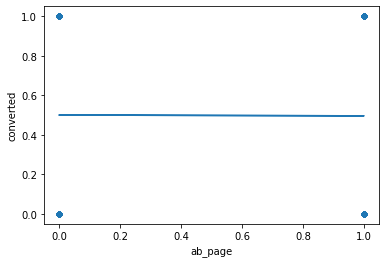

In [53]:
import statsmodels.api as sm
import scipy
model = sm.OLS(df_new.ab_page, sm.add_constant (df_new.converted))
p = model.fit().params
x = df_new.ab_page
ax = df_new.plot(x='ab_page', y='converted', kind ='scatter')
ax.plot(x, p.const+p.converted*x)
print("correlation:", scipy.stats.pearsonr(df2.converted, df2.user_id))

<a id='conclusions'></a>
## Conclusions

*The A/B test shows that the alternative hypothesis should be rejected and keep with the null, however further invetigation for the rate of conversion in different countries shows that the conversion is affected by the place where users are from, Canada shows more conversion with the new page while US and UK shows more conversion with the old one, this is not enough to take a decision as the conversion rate in US and UK may be because of rejecting the change and users only need time to get confortable with the new page, find the reason of the difference between Canada, UK and US should be followed by more investigation of whether the users are old or new ones, and since when they are using the page, so in conclusion, the test should continue and more data needed to render a decision.*

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.